<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L05/MC_reliability_estimation_quadratic_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Example MC-integration: Estimation of Chance Constraints**

* Chance constraint are generally intractable analytically (multidimensional probabilistic integral)

* Monte Carlo simulation allows estimating these integrals numerically.

  * MC useful when dealing with complex function, example $g$ non-linear, discontinuous, etc.
  * Numerical Estiamtion of probabilities



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, multivariate_normal
import scipy.stats as stats
from numpy.random import multivariate_normal as mvn_rnd


# Problem Statement:
Consider a structural reliability analysis problem.


### A performance function for a system

* A simple equation defines the structural integrity of the system

$$g(x,\theta)  =2-\theta_1x_1 +\theta_2 x_2 + \theta_3 x_1x_2$$

where

* $\theta$ gives the structure design, (assume $\theta=[1, 1, 0.5]$ is a baseline design)
* $x_1$ Random operational, $x_2$ Random wind speed
* $x_1,x_2$ are distributed as $f_X(x)$ (we will provide a function DGM to generate samples from it)

We loose structural integrity if:
$$g(x,\theta)  \leq 0 $$


   $ ~$

### **Taks 1**. Define the indicator function


   $
   I(x) =
   \begin{cases}
   1 & \text{if } g(x, \theta) \leq 0, \\
   0 & \text{otherwise.}
   \end{cases}
   $


### **Taks 2**. Estimate the distribution of $f_g$ with  $x \sim f_X(x)$

### **Taks 3**. Estimate Prob. via MC integration
  
$$\mathbb{P}[g(x,\theta) \leq 0], ~~~~\text{with}~~~~ x \sim f_X(x)$$


### **Taks 4**. Visualize failure region and plot convergence of the probability estimate
$$\{x : g(x, \theta)\leq 0\}$$

   $ ~$

In [ ]:
#@title The Probabilistic Model -> Generate samples/scenarios $x\sim f_X(x)$.

# =====================================================
# The Probabilistic Model
# =====================================================

def DGM(n_samples: int = 5000):
  """
  A data generating mechanism
    Args:
        n_samples: integer number of samples
    Returns:
        X: the samples
        marginals: the marginal distributions
        corr_matrix: a correlation matrix

  """
  np.random.seed(42)

  # Define marginal distributions (e.g., Lognormal and Weibull)
  marginals = [stats.lognorm(s=0.5, scale=np.exp(0.5)),   # Lognormal
              stats.weibull_min(c=12.0, scale=1.0)]       # Weibul

  # Define correlation matrix
  corr_matrix = np.array([[1.0, 0.6], [0.6, 1.0]])

  # Generate correlated samples from a multivariate gaussian distribution
  Z = mvn_rnd(mean=np.zeros(2),
              cov=corr_matrix,
              size=n_samples)

  U = stats.norm.cdf(Z)  # Transform to uniform space
  X = np.zeros_like(U)   # X contains all zeros same size as U

  for i in range(2):
    X[:, i] = marginals[i].ppf(U[:, i])  # Transform to physical space using inverse CDF

  return X, marginals, corr_matrix


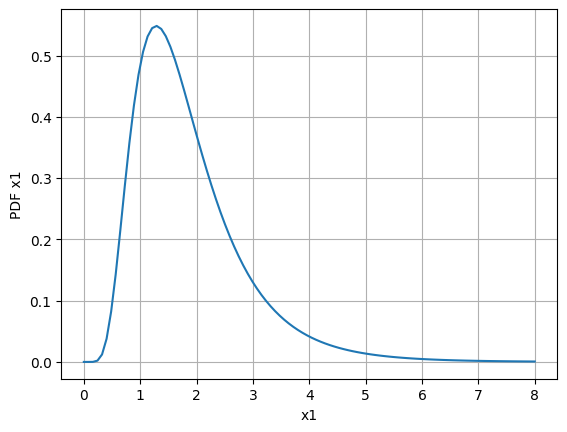

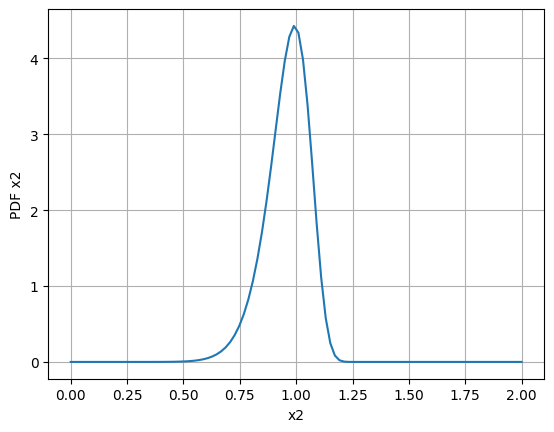

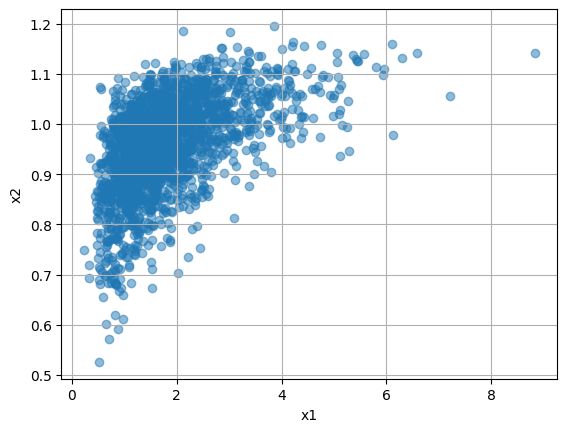

In [ ]:
# example
X, marginals, corr_matrix =  DGM(2000)

x_linspace = np.linspace(-0,8,100)
plt.plot(x_linspace, marginals[0].pdf(x_linspace))
plt.xlabel('x1')
plt.ylabel('PDF x1')
plt.grid()
plt.show()

x_linspace = np.linspace(-0,2,100)
plt.plot(x_linspace, marginals[1].pdf(x_linspace))
plt.xlabel('x2')
plt.ylabel('PDF x2')
plt.grid()
plt.show()

plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.show()

#Start

### Taks 1. Define the indicator function


   $
   I(x) =
   \begin{cases}
   1 & \text{if } g(x, \theta) \leq 0, \\
   0 & \text{otherwise.}
   \end{cases}
   $


In [ ]:
# Define the Performance Function g(x,theta)
def g_fun(x1, x2, theta = None):
    """
    Performance function g(x,theta).
    Args:
        x1, x2: Input variables.
        theta: Design parameters
    Returns:
        Value of the performance function.
    """
    if theta is None:
      theta = [1, 1, 0.5]

    return 2 - theta[0]*x1 + theta[1]*x2 + theta[2]* x1*x2

# Define the Indicator Function I(x)
def I_fun(x1, x2, theta = None):
    """
    Indicator function I(x).
    Args:
        x1, x2: Input variables.
    Returns:
        1 if g(x) <= 0 (failure), 0 otherwise.
    """
    return g_fun(x1, x2, theta)<=0

### Taks 2. Estimate the distribution of $f_g$ with  $x \sim f_X(x)$ via MC simulation


### Monte Carlo (MC)  

Monte Carlo estimation provides a sample-based approach to approximate the failure probability $P_f(\theta)$ or equivalently $R(\theta)$.

1. Draw $n$ independent samples $\{x_i\}_{i=1}^n$ from the distribution $f_X(x)$

2. For each sample $x_i$, evaluate $g(x_i; \theta)$ and $I(x_i)$.  


3. The Monte Carlo **Estimation** of $P_f(\theta)$ is the expectation of the indicator function

   $$
   \hat{P}_f(\theta) = \frac{1}{N} \sum_{i=1}^N I(x_i).
   $$



4. Using the complement, the estimate $P_R(\theta) = 1 - \hat{P}_f(\theta)$.

5. Visualize region $\{x : g(x)\leq 0\}$
      

In [ ]:
# Monte Carlo Estimation
# 1. sample
X, _, _ =   DGM(10_000) # COMPLETE...use the DGM to generate samples

# 2. evalluate system response
g_samples =  g_fun(X[:,0], X[:,1])

# 3. probability distribution of g_samples
g_samples_sorted = np.sort(g_samples)
n = len(g_samples)
g_cdf_empirical = np.arange(1, n + 1) / n

In [ ]:
g_sams = [g_fun(x[0],x[1]) for x in X]
g_sams = np.array(g_sams)
print(g_sams)

[2.18400893 2.53121496 1.99522333 ... 2.35834777 2.38838167 1.97228798]


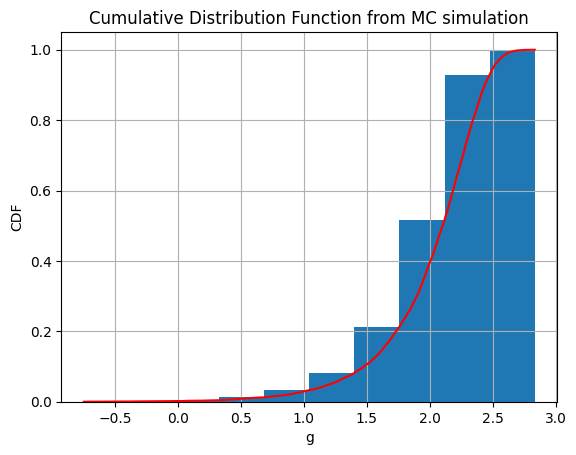

In [ ]:
plt.hist(g_samples, cumulative=True, density=True)
plt.plot(g_samples_sorted, g_cdf_empirical, c='r')
plt.grid()
plt.xlabel('g')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function from MC simulation')
plt.show()

### Taks 3. Estimate Prob. via MC integration
  
$$\mathbb{P}[g(x,\theta) \leq 0], ~~~~\text{with}~~~~ x \sim f_X(x)$$



In [ ]:
# Monte Carlo Estimation
# 1. sample
X, _, _ =  DGM(50_000)

# 2. evalluate system response
I_sams = [I_fun(x[0],x[1]) for x in X]

# 3. samples-based estimate
mc_estimate_pof = np.mean(I_sams) # COMPLETE...Expetation of the indicator function

print(f"Estimated probability of failure (small) = {mc_estimate_pof:.6f}")

# 4. samples-based estimate
mc_estimate_reliability = 1- mc_estimate_pof # COMPLETE... use complement rule
print(f"Estimated probability of the reliability = {mc_estimate_reliability:.6f}")


Estimated probability of failure (small) = 0.002240
Estimated probability of the reliability = 0.997760



### Taks 4. Visualize failure region and plot convergence of the probability estimate
$$\{x : g(x, \theta)\leq 0\}$$

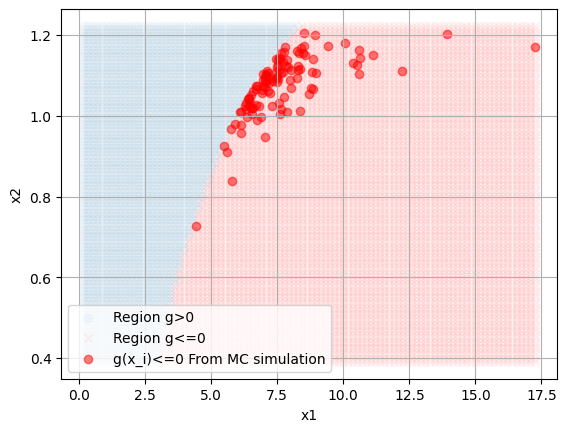

In [ ]:
# Visualization region
X_grid_x1, X_grid_x2 = np.meshgrid(np.linspace(min(X[:,0]),max(X[:,0]),100), np.linspace(min(X[:,1]),max(X[:,1]),100))
X_grid = np.stack((X_grid_x1.ravel(), X_grid_x2.ravel()), axis=-1)
I_grid = np.array([I_fun(x[0], x[1]) for x in X_grid])
plt.scatter(X_grid[I_grid==0,0], X_grid[I_grid==0,1], alpha=0.03, label=f"Region g>0")
plt.scatter(X_grid[I_grid==1,0], X_grid[I_grid==1,1], alpha=0.05, c='r', marker='x', label="Region g<=0")
plt.scatter(X[I_sams, 0], X[I_sams, 1], alpha=0.5, c='r', marker='o', label="g(x_i)<=0 From MC simulation")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()

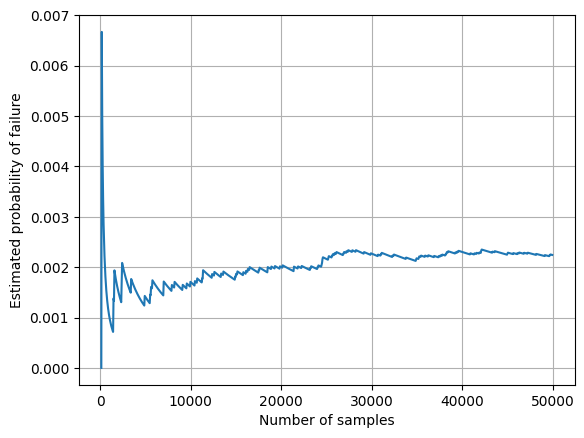

In [ ]:
# 6. Convergence of the Pf estimator
steps_2_eval = range(100,len(I_sams),50)
Pf_step_k = np.array([np.mean(I_sams[:k]) for k in steps_2_eval])
plt.plot(steps_2_eval, Pf_step_k)
plt.xlabel('Number of samples')
plt.ylabel('Estimated probability of failure')
plt.grid()
plt.show()